In [ ]:
%%capture
!pip install unsloth
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 
dtype = None 
load_in_4bit = True 

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/mistral-7b-v0.3",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.8.5: Fast Mistral patching. Transformers: 4.55.0.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.3.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.14G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/157 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/446 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, 
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, 
    bias = "none",  
    use_gradient_checkpointing = "unsloth", 
    random_state = 3407,
    use_rslora = False, 
    loftq_config = None, 
)

Unsloth 2025.8.5 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [ ]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""


EOS_TOKEN = tokenizer.eos_token 
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = load_dataset('json', data_files='/content/veriler (1).jsonl', split='train')
dataset = dataset.map(formatting_prompts_func, batched = True,)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/225 [00:00<?, ? examples/s]

In [ ]:
try:
    print("Veri seti özeti:")
    print("-" * 20)
    print(f"Toplam örnek sayısı: {len(dataset)}")

    print("Kolon isimleri:")
    for feature in dataset.features:
        print(f"- {feature}")

    print("-" * 20)
    print("İlk örnek:")
    print(dataset[0])

except NameError:
    print("Hata: 'dataset' objesi tanımlı değil. Lütfen önce 'load_dataset' ve 'map' işlemlerini gerçekleştirin.")


Veri seti özeti:
--------------------
Toplam örnek sayısı: 225
Kolon isimleri:
- instruction
- input
- output
- text
--------------------
İlk örnek:
{'instruction': "Kullanıcı sorusuna ve konuşma geçmişine bakarak bir sonraki adımın ne olması gerektiğine karar ver: 'generate_sql', 'vector_search', ya da 'respond'.", 'input': {'original_query': 'Bir grup adamın tek bir odada tartıştığı o eski, siyah beyaz filmin süresi ne kadardı?', 'tool_results': [], 'db_schema': None, 'sql_attempts': None, 'successful_results': None, 'output': None}, 'output': 'vector_search', 'text': "Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nKullanıcı sorusuna ve konuşma geçmişine bakarak bir sonraki adımın ne olması gerektiğine karar ver: 'generate_sql', 'vector_search', ya da 'respond'.\n\n### Input:\n{'original_query': 'Bir grup adamın tek bir odada tartıştığı o eski, siyah bey

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, 
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = -1, 
        num_train_epochs=5,
        learning_rate = 2e-5,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", 
    ),
)

Unsloth: Tokenizing ["text"]:   0%|          | 0/225 [00:00<?, ? examples/s]

In [ ]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA L4. Max memory = 22.161 GB.
6.766 GB of memory reserved.


In [8]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 225 | Num Epochs = 5 | Total steps = 145
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040 of 7,289,966,592 (0.58% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.891600
2,1.684800
3,1.730100
4,1.938700
5,1.881500
6,1.729500
7,1.639300
8,1.645500
9,1.534600
10,1.557900


In [ ]:
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

529.1399 seconds used for training.
8.82 minutes used for training.
Peak reserved memory = 6.766 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 30.531 %.
Peak reserved memory for training % of max memory = 0.0 %.


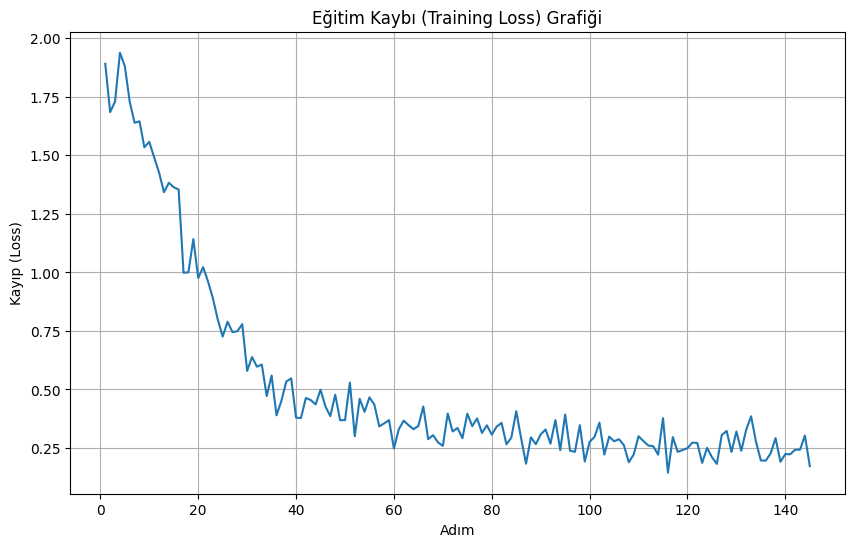

Eğitim Kaybı grafiği 'training_loss_graph.png' adıyla kaydedildi.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

try:
    training_metrics = trainer_stats.metrics
    log_history = trainer.state.log_history
    steps = [log['step'] for log in log_history if 'loss' in log]
    losses = [log['loss'] for log in log_history if 'loss' in log]

    df_loss = pd.DataFrame({'Step': steps, 'Training Loss': losses})

    plt.figure(figsize=(10, 6))
    plt.plot(df_loss['Step'], df_loss['Training Loss'], linestyle='-')
    plt.title('Eğitim Kaybı (Training Loss) Grafiği')
    plt.xlabel('Adım')
    plt.ylabel('Kayıp (Loss)')
    plt.grid(True)

    plt.savefig('training_loss_graph.png')
    plt.show()

    print("Eğitim Kaybı grafiği 'training_loss_graph.png' adıyla kaydedildi.")

except NameError:
    print("Hata: 'trainer_stats' objesi bulunamadı. Lütfen önce `trainer.train()` komutunu çalıştırın.")
except KeyError:
    print("Hata: `trainer_stats` objesi gerekli 'log_history' metriklerini içermiyor.")

In [ ]:
FastLanguageModel.for_inference(model) 
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Kullanıcı sorusuna ve konuşma geçmişine bakarak bir sonraki adımın ne olması gerektiğine karar ver: 'generate_sql', 'vector_search', ya da 'respond'.", # instruction
        {"original_query": "O filmde kimler oynuyordu?", "tool_results": [{"router_decision": "vector_search"}, {"vector_result": ["Cast Away"]}]}, # input
        "", 
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 256, use_cache = True)
tokenizer.batch_decode(outputs)

["<s> Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nKullanıcı sorusuna ve konuşma geçmişine bakarak bir sonraki adımın ne olması gerektiğine karar ver: 'generate_sql', 'vector_search', ya da 'respond'.\n\n### Input:\n{'original_query': 'O filmde kimler oynuyordu?', 'tool_results': [{'router_decision': 'vector_search'}, {'vector_result': ['Cast Away']}]}\n\n### Response:\ngenerate_sql</s>"]

In [ ]:
model.save_pretrained("lora_model") 
tokenizer.save_pretrained("lora_model")

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.model',
 'lora_model/added_tokens.json',
 'lora_model/tokenizer.json')

In [ ]:
if False:
    # I highly do NOT suggest - use Unsloth if possible
    from peft import AutoPeftModelForCausalLM
    from transformers import AutoTokenizer
    model = AutoPeftModelForCausalLM.from_pretrained(
        "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = load_in_4bit,
    )
    tokenizer = AutoTokenizer.from_pretrained("lora_model")

In [ ]:
# Merge to 16bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
#if True: model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
if True: model.push_to_hub_merged("mmmmmmabel/cokelek-v2", tokenizer, save_method = "lora", token = "")

  0%|          | 0/1 [00:00<?, ?it/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Cache check failed: model-00001-of-00003.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Unsloth: Merging weights into 16bit:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  33%|███▎      | 1/3 [01:36<03:13, 96.59s/it]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  67%|██████▋   | 2/3 [03:19<01:40, 100.07s/it]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 3/3 [04:59<00:00, 99.86s/it] 
